In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import numpy as np
import os

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iwann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\iwann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iwann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
#Insert data files

base_dir = os.getcwd()# Get the directory of the current script
catalog_path = os.path.join(base_dir, "b_product_catalog.csv")
desc_path = os.path.join(base_dir, "b_unstructured_descriptions.csv")

catalog = pd.read_csv(catalog_path)
descriptions = pd.read_csv(desc_path)

In [3]:
# Filter out most common filler words from descriptions
def filter_stopwords(descriptions):
    stop_words = set(stopwords.words('english'))
    more_stopwords = {'size', 'material', 'color', 'brand', 'product', 'feature', 'help','thanks', 'thank', 'modern', 'hi', 'hey', 'hello', 'want', 'need', 'searching', 'like', 'looking', 'find', 'please', 'asap', 'help', 'something', 'good', 'afternoon', 'morning', 'option'}
    for i, description in enumerate(descriptions['Unstructured_Description']):
        description_tokens = word_tokenize(description)
        filtered_tokens = [word.lower() for word in description_tokens if word.lower() not in stop_words and word.lower() not in more_stopwords and word.isalpha()]
        description_filtered = ' '.join(filtered_tokens)
        descriptions.at[i, 'Fixed_Description'] = description_filtered
    return descriptions

In [4]:
#Normalize different size formats
def normalize_sizes(text):
    
    size_map = {
    "extra extra small": "xxs",
    "extra small": "xs",
    "small": "s",
    "medium": "m",
    "large": "l",
    "extra large": "xl",
    "extra extra large": "xxl"
    }
    # Lowercase for consistency
    text = text.lower()
    # Replace using regex with word boundaries
    for short, full in size_map.items():
        text = re.sub(rf"\b{short}\b", full, text)
    return text



In [5]:
# Apply normalization to descriptions
def normalize_sizes_in_description(descriptions):
    descriptions["Normalized_Description"] = descriptions["Fixed_Description"].apply(normalize_sizes)
    return descriptions

In [6]:
# Create dictionaries of unique catalog attributes
def unique_catalog_attributes(catalog):
    
    products = catalog['Subcategory'].unique()
    brands = catalog['Brand'].unique()
    colors = catalog['Color'].unique()
    sizes = catalog['Size'].unique()
    materials = catalog['Material'].unique()
    features = (
        catalog['Features']
        .dropna()
        .apply(lambda x: x.split('|'))
        .explode()
        .unique()
    )
    # Combine all attributes into a single list for typo-handling
    all_attributes = list(products) + list(brands) + list(colors) + list(sizes) + list(materials) + list(features)
    all_attributes = [attr.lower() for attr in all_attributes if isinstance(attr, str)] 

    # Add type of attribute next to value to provide more context for similarity matching

    brands_array = [[b.lower(), 'brand'] for b in brands]
    colors_array = [[c.lower(), 'color'] for c in colors]
    features_array = [[f.lower(), 'feature'] for f in features]
    materials_array = [[m.lower(), 'material'] for m in materials]
    products_array = [[p.lower(), 'product'] for p in products]
    sizes_array = [[s.lower(), 'size'] for s in sizes]

    attribute_dictionary = pd.DataFrame(
        colors_array + features_array+ products_array+sizes_array+materials_array+brands_array,
        columns=['Attribute', 'Type']
    )

    attribute_dictionary["Contextual"] = attribute_dictionary["Type"] + " " + attribute_dictionary["Attribute"]
    return all_attributes, attribute_dictionary, brands, colors, features, materials, products, sizes 


In [7]:
# Compare all words from free text descriptions to catalog attributes and correct typos (letter-by-letter matching)
def correct_typos_in_descriptions(descriptions, all_attributes):
    from rapidfuzz import process, fuzz
    fixed = []
    for ind, description in enumerate(descriptions['Normalized_Description']):
        description_lower = description.lower()
        tokens = word_tokenize(description_lower)
        for index, word in enumerate(tokens):
            match, score, _ = process.extractOne(word, all_attributes, scorer=fuzz.ratio)
            if score >=75:
                tokens[index] = match
                fixed.append([word, match, score])
        description_new = ' '.join(tokens)
        descriptions.at[ind, 'Typos_Fixed'] = description_new

    fixed = pd.DataFrame(fixed, columns=['Original', 'Matched', 'Score'])
    return descriptions


In [8]:
# Load SentenceTransformer model
def get_model(model_name):
    model = SentenceTransformer(model_name)
    return model


In [9]:
# After fixing the typos, find closest contextual match for each word in the description using embeddings (context-based similarity matching)
def find_closest_contextual_match(token, dictionary, dict_embeddings, model): 
    
    best_match = None
    best_score = -1
    best_dict_row = None
    best_context = None

    for type_value in dictionary['Type'].unique():
        token_context = f"{type_value} {token}"
        token_emb = model.encode(token_context, normalize_embeddings=True)

        scores = util.cos_sim(token_emb, dict_embeddings)[0].cpu().numpy()
        best_idx = np.argmax(scores)
        score = scores[best_idx]

        if score > best_score:
            best_score = score
            best_match = dictionary.iloc[best_idx]['Attribute']
            best_match_type = dictionary.iloc[best_idx]['Type']
            best_context = token_context

    return best_match, best_context, best_match_type, float(best_score)

In [10]:
# Iterate through all words in the description and find closest contextual match
def contextual_attribute_matching(descriptions, attribute_dictionary, model):
    dict_embeddings = model.encode(attribute_dictionary["Contextual"], normalize_embeddings=True)
    fixed_1 = []
    words = []
    for ind, description in enumerate(descriptions['Typos_Fixed']):
        description_lower = description.lower()
        tokens = word_tokenize(description_lower)
        for index, word in enumerate(tokens):
            words.append(word)
            match_attr, match_word, match_type, match_score = find_closest_contextual_match(
                word,
                attribute_dictionary,
                dict_embeddings, 
                model
            )
            if match_score >= 0.75 and match_type!= 'brand' and match_type != 'size':
                tokens[index] = match_attr
                fixed_1.append([word, match_attr, match_word, match_score])
            descriptions.at[ind, 'Context_Matched_Description'] = ' '.join(tokens)
    df = pd.DataFrame(fixed_1, columns=['Original', 'Matched_Attribute', 'Matched_Word', 'Score'])
    return descriptions

In [11]:
# Recognize dictionary attributes inside the free text descriptions
def extract_attribute(text, keywords):
    text_lower = text.lower()
    for k in keywords:
        if " " + k.lower() + " " in text_lower or text_lower.endswith(" " + k.lower()) or text_lower.startswith(k.lower() + " ") or text_lower == k.lower():
            return k
    return None

# Extract any valid attributes included in the description
def extract_attributes_from_text(text, brands, colors, features, materials, products, sizes):
    return {
        "Brand": extract_attribute(text, brands),
        "Color": extract_attribute(text, colors),
        "Features": extract_attribute(text, features),
        "Material": extract_attribute(text, materials),
        "Product": extract_attribute(text, products),
        "Size": extract_attribute(text, sizes)
    }


In [12]:
# Iterate the descriptions dataframe and append found attributes as new columns
def extract_attributes(descriptions, colors, brands, materials, products, sizes, features):
    descriptions["extracted"] = descriptions['Context_Matched_Description'].apply(
        lambda text: extract_attributes_from_text(text, colors, brands, materials, products, sizes, features)
    )
    descriptions_final = descriptions[['Unstructured_Description','Typos_Fixed']]
    descriptions_final.loc[:, 'Brand'] = descriptions['extracted'].apply(lambda x: x['Brand'])
    descriptions_final.loc[:, 'Color'] = descriptions['extracted'].apply(lambda x: x['Color'])
    descriptions_final.loc[:, 'Material'] = descriptions['extracted'].apply(lambda x: x['Material'])
    descriptions_final.loc[:, 'Product'] = descriptions['extracted'].apply(lambda x: x['Product'])
    descriptions_final.loc[:, 'Size'] = descriptions['extracted'].apply(lambda x: x['Size'])
    descriptions_final.loc[:, 'Features'] = descriptions['extracted'].apply(lambda x: x['Features'])
    return descriptions_final

In [13]:
# Match the cleaned descriptions to the product catalog using embeddings similarity
def match_descriptions_to_catalog(descriptions_final, catalog, model):

    catalog_matching = catalog[['SKU']]
    catalog_matching.loc[:, 'Full Description'] = catalog['Category'] + ' ' + catalog['Subcategory'] + ' ' + catalog['Brand'] + ' ' + catalog['Material'] + ' ' + catalog['Color'] + ' ' + catalog['Size'] + ' ' + catalog['Features'].fillna('').str.replace('|', ' ') + ' ' + catalog['Season']

    # Create descriptions embeddings
    embeddings_final = model.encode(
        descriptions_final['Typos_Fixed'].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )

    # Create catalog embeddings
    embeddings_catalog = model.encode(
        catalog_matching['Full Description'].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )

    # Compute cosine similarity matrix
    similarity_matrix = util.cos_sim(embeddings_final, embeddings_catalog)

    top_matches = []
    # For each description, find top 3 matches from catalog
    for i in range(len(descriptions_final)):

        scores = similarity_matrix[i]
        
        top_idx = scores.topk(3).indices.tolist()
        
        matches = pd.DataFrame({
            'full_description': catalog_matching.iloc[top_idx]['Full Description'].values,
            'SKU': catalog_matching.iloc[top_idx]['SKU'].values,
            'score': scores[top_idx].cpu().numpy()
        })
        top_matches.append(matches)

    descriptions_final['top_matches'] = top_matches
    return descriptions_final

In [14]:
# Plot distribution of top similarity scores (best match for each description)
def visualize_top_scores(descriptions_final):
    descriptions_final['top_score'] = descriptions_final['top_matches'].apply(
    lambda df: df.iloc[0]['score'] if len(df) > 0 else None
)
    plt.hist(descriptions_final['top_score'], bins=20, edgecolor='black')
    plt.xlabel('Top Match Similarity Score')
    plt.ylabel('Number of Products')
    plt.title('Distribution of Top Similarity Scores')
    plt.show()

In [15]:
# Run the pipeline and evaluate the model
def run_pipeline(descriptions, catalog, model_name):
    descriptions = filter_stopwords(descriptions)
    descriptions = normalize_sizes_in_description(descriptions)
    all_attributes, attribute_dictionary, brands, colors, features, materials, products, sizes = unique_catalog_attributes(catalog)
    descriptions = correct_typos_in_descriptions(descriptions, all_attributes)
    model = get_model(model_name)
    descriptions = contextual_attribute_matching(descriptions, attribute_dictionary, model)
    descriptions_final = extract_attributes(descriptions, brands, colors, features, materials, products, sizes )
    descriptions_final = match_descriptions_to_catalog(descriptions_final, catalog, model)
    visualize_top_scores(descriptions_final)
    return descriptions_final

In [16]:
# Evaluate results by comparing matched SKUs to original SKUs from test dataset
def results_evaluation(descriptions_initial, descriptions_final):
    correct_matches = 0
    total_descriptions = len(descriptions_final)
    descriptions_final = pd.merge(descriptions_final, descriptions_initial, on='Unstructured_Description', how='inner')

    for index, row in descriptions_final.iterrows():
        top_match_sku = row['top_matches'].iloc[0]['SKU']
        if str(top_match_sku) == str(row['SKU_Original']):
            correct_matches += 1

    accuracy = correct_matches / total_descriptions if total_descriptions > 0 else 0
    print(f"Total Descriptions: {total_descriptions}")
    print(f"Correct Matches: {correct_matches}")
    print(f"Accuracy: {accuracy:.2%}")

In [17]:
def results_evaluation_top3(descriptions_initial, descriptions_final):
    correct_matches = 0
    total_descriptions = len(descriptions_final)

    # Merge to bring original SKU info
    descriptions_final = pd.merge(
        descriptions_final,
        descriptions_initial,
        on='Unstructured_Description',
        how='inner'
    )

    for index, row in descriptions_final.iterrows():
        # Get the top 3 SKUs from your stored matches
        top_match_skus = row['top_matches']['SKU'].astype(str).tolist()

        # Compare to the true SKU
        if str(row['SKU_Original']) in top_match_skus:
            correct_matches += 1

    recall_at_3 = correct_matches / total_descriptions if total_descriptions > 0 else 0

    print(f"Total Descriptions: {total_descriptions}")
    print(f"Correct Top-3 Matches: {correct_matches}")
    print(f"Recall@3 (Top-3 Accuracy): {recall_at_3:.2%}")

    return recall_at_3

C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Brand'] = descriptions['extracted'].apply(lambda x: x['Brand'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Color'] = descriptions['extracted'].apply(lambda x: x['Color'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:9: SettingWithCopyWarning: 
A value is tryi

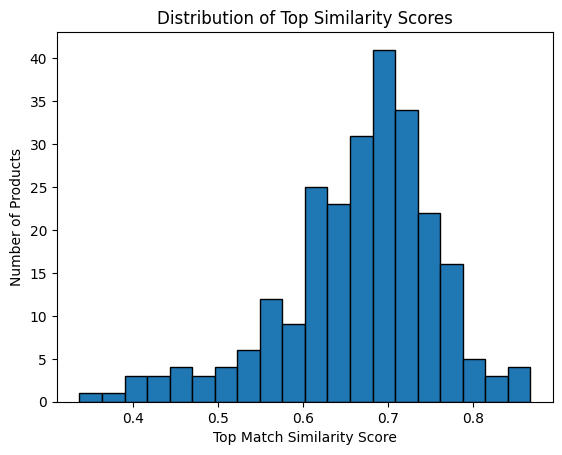

,Unstructured_Description,Typos_Fixed,Brand,Color,Material,Product,Size,Features,top_matches,top_score
0,Do you carry Style Pants for Fall 2025?,carry style pants fall,Style,None,None,Pants,None,None,full_descr...,0.578754
1,"Looking for Green Boots, size L.",green boots l,None,Green,None,Boots,L,None,full_descr...,0.665408
2,Searching for the Modern blazer finished in da...,blazer finished dark gray xxl,None,Black,None,Blazer,XXL,None,full_descr...,0.699939
3,Need blue sundress that is breathable and flex...,blue sundress breathable flexible fall,None,Blue,None,Sundress,None,Breathable,full_descr...,0.700669
4,"Looking for Beige Gown, size L.",beige gown l,None,Beige,None,Gown,L,None,full_descr...,0.754873
...,...,...,...,...,...,...,...,...,...,...
245,Need Classic Blouse Cream size S,classic blouse cream,Classic,Cream,None,Blouse,None,None,full_descr...,0.630740
246,"Charcoal Sandals from Modern, size M",charcoal sandals,None,Charcoal,None,Sandals,None,None,full_descr...,0.756918
247,Do you stock Alpine's t-shirt in that charcoal...,stock alpine charcoal tone xs,Alpine,Charcoal,None,None,XS,None,full_descr...,0.565359
248,Looking for Elite Sundress Red L,elite sundress red l,Elite,Red,None,Sundress,L,None,full_descr...,0.696588


In [18]:
run_pipeline(descriptions, catalog, 'all-MiniLM-L6-v2')

C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Brand'] = descriptions['extracted'].apply(lambda x: x['Brand'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Color'] = descriptions['extracted'].apply(lambda x: x['Color'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:9: SettingWithCopyWarning: 
A value is tryi

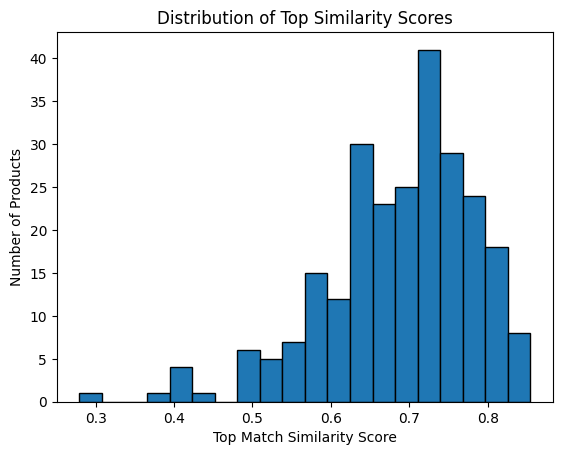

,Unstructured_Description,Typos_Fixed,Brand,Color,Material,Product,Size,Features,top_matches,top_score
0,Do you carry Style Pants for Fall 2025?,carry style pants fall,Style,None,None,Pants,None,None,full_descr...,0.481517
1,"Looking for Green Boots, size L.",green boots l,None,Green,None,Boots,L,None,full_descr...,0.651874
2,Searching for the Modern blazer finished in da...,blazer finished dark gray xxl,None,Black,None,Blazer,XXL,None,full_descr...,0.819148
3,Need blue sundress that is breathable and flex...,blue sundress breathable flexible fall,None,Blue,None,Sundress,None,Breathable,full_descr...,0.641019
4,"Looking for Beige Gown, size L.",beige gown l,None,Beige,None,Gown,L,None,full_descri...,0.751006
...,...,...,...,...,...,...,...,...,...,...
245,Need Classic Blouse Cream size S,classic blouse cream,Classic,Cream,None,Blouse,None,None,full_descr...,0.637078
246,"Charcoal Sandals from Modern, size M",charcoal sandals,None,Charcoal,None,Sandals,None,None,full_descr...,0.740690
247,Do you stock Alpine's t-shirt in that charcoal...,stock alpine charcoal tone xs,Alpine,Charcoal,None,None,XS,None,full_descript...,0.491105
248,Looking for Elite Sundress Red L,elite sundress red l,Elite,Red,None,Sundress,L,None,full_descr...,0.698241


In [19]:
run_pipeline(descriptions, catalog, 'all-mpnet-base-v2')

C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Brand'] = descriptions['extracted'].apply(lambda x: x['Brand'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Color'] = descriptions['extracted'].apply(lambda x: x['Color'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:9: SettingWithCopyWarning: 
A value is tryi

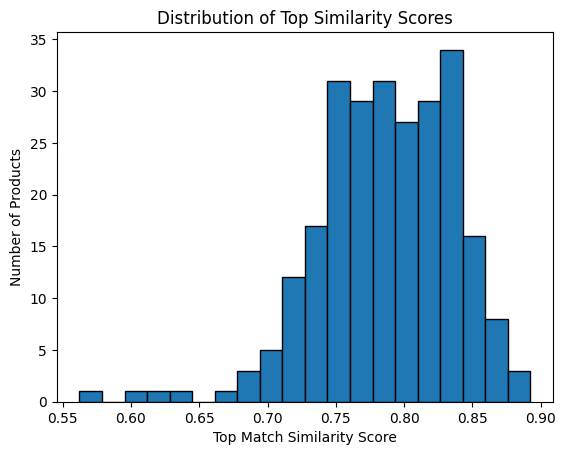

In [20]:
descriptions_final = run_pipeline(descriptions, catalog, 'BAAI/bge-large-en-v1.5')


In [27]:
descriptions_final.to_csv('final_results.csv', sep = ';', index=False)

C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Brand'] = descriptions['extracted'].apply(lambda x: x['Brand'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions_final.loc[:, 'Color'] = descriptions['extracted'].apply(lambda x: x['Color'])
C:\Users\iwann\AppData\Local\Temp\ipykernel_18380\316178688.py:9: SettingWithCopyWarning: 
A value is tryi

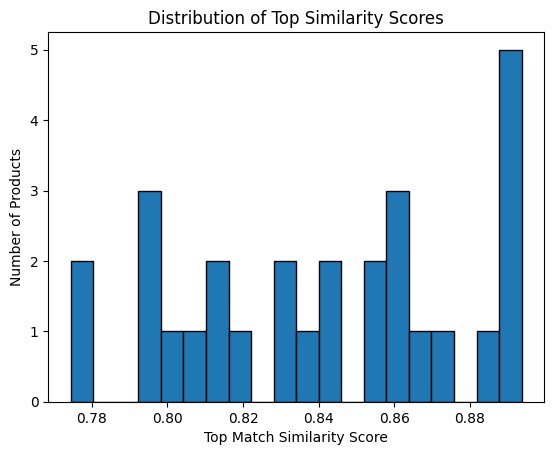

Total Descriptions: 28
Correct Matches: 26
Accuracy: 92.86%
Total Descriptions: 28
Correct Top-3 Matches: 27
Recall@3 (Top-3 Accuracy): 96.43%


0.9642857142857143

In [26]:
#Insert data files

sample_path = os.path.join(base_dir, "sample_dataset.csv")

descriptions = pd.read_csv(sample_path)
descriptions_final = run_pipeline(descriptions, catalog, 'BAAI/bge-large-en-v1.5')
results_evaluation(descriptions, descriptions_final)
results_evaluation_top3(descriptions, descriptions_final)